In [1]:
%matplotlib inline


# A 250-hPa Hemispheric Map using Python


This example plots a hemispheric plot of GFS 250-hPa Geopotential Heights and
wind speed in knots.


In [2]:
# =======
# modules

# time
from datetime import datetime, timedelta
# plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# metply
import metpy.calc as mpcalc
from metpy.units import units
# netcdf4
from netCDF4 import num2date
# numpy
import numpy as np
import scipy.ndimage as ndimage 
# weather data
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

In [3]:
# =======
# define Dataset and Time

# Set the time range
now = datetime.utcnow() #current
end = now + timedelta(days=2) # end of forecast
print(end)

# set geography
north = 90; south = 0; east = 360; west = 0

# available THREDDS catalog 
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog.xml')
#print('available THREDDS catalog: ', list(cat.catalog_refs))

2019-12-22 23:16:29.144370


In [4]:
# =======
# Latest GFS Dataset
latest_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/latest.xml')
print(latest_gfs.datasets)

# pull out this dataset and get the NCSS access point
latest_ds = list(latest_gfs.datasets.values())[0]
# Create NCSS object to access the NetcdfSubset
ncss = NCSS(latest_ds.access_urls['NetcdfSubset'])

# Query for Latest GFS Run
# NOTE: different number of vertical levels for geopot and wind

# geopotential height
query_geopot = ncss.query().time_range(now, end).lonlat_box(north = north, south = south, east = east, west = west).vertical_level(25000).accept('netcdf4')    # use time(now) to get only current timestep
query_geopot.variables('Geopotential_height_isobaric').add_lonlat()

# wind
query_wind = ncss.query().time_range(now, end).lonlat_box(north = north, south = south, east = east, west = west).vertical_level(25000).accept('netcdf4')    # use time(now) to get only current timestep
query_wind.variables('u-component_of_wind_isobaric',
                    'v-component_of_wind_isobaric').add_lonlat()

# Actually getting (request) the data
data_geopot = ncss.get_data(query_geopot)
data_wind = ncss.get_data(query_wind)

['GFS_Global_0p5deg_20191220_1200.grib2']


The next cell will take the downloaded data and parse it to different variables
for use later on. Add a cyclic point using the cartopy utility add_cyclic_point
to the longitudes (the cyclic dimension) as well as any data that is being
contoured or filled.



In [6]:
print(list(data_geopot.variables))

lat = data_geopot.variables['lat'][:]
lon = data_geopot.variables['lon'][:]

# Converting times using the num2date function available through netCDF4
times = data_geopot.variables['time3']
vtimes = num2date(times[:], times.units)

# Smooth the 250-hPa heights using a gaussian filter from scipy.ndimage
hgt_250, lon = cutil.add_cyclic_point(data_geopot.variables['Geopotential_height_isobaric'][:],
                                      coord=lon)
print(np.shape(hgt_250))
Z_250 = ndimage.gaussian_filter(hgt_250[:, 0, :, :], sigma=3, order=0)
print(np.shape(Z_250))

u250 = (units(data_wind.variables['u-component_of_wind_isobaric'].units) *
        data_wind.variables['u-component_of_wind_isobaric'][:, 0, :, :])
v250 = (units(data_wind.variables['v-component_of_wind_isobaric'].units) *
        data_wind.variables['v-component_of_wind_isobaric'][:, 0, :, :])
u250 = u250.units * cutil.add_cyclic_point(u250)
v250 = v250.units * cutil.add_cyclic_point(v250)
wspd250 = mpcalc.wind_speed(u250, v250)
print(np.shape(wspd250))
print(np.shape(u250))
print(len(times))

['Geopotential_height_isobaric', 'time3', 'isobaric6', 'lat', 'lon', 'LatLon_Projection']
(16, 1, 181, 721)
(16, 181, 721)
(16, 181, 721)
(16, 181, 721)
16


The next cell sets up the geographic details for the plot that we are going to do later.
This is done using the Cartopy package. We will also bring in some geographic data to
geo-reference the image for us.



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


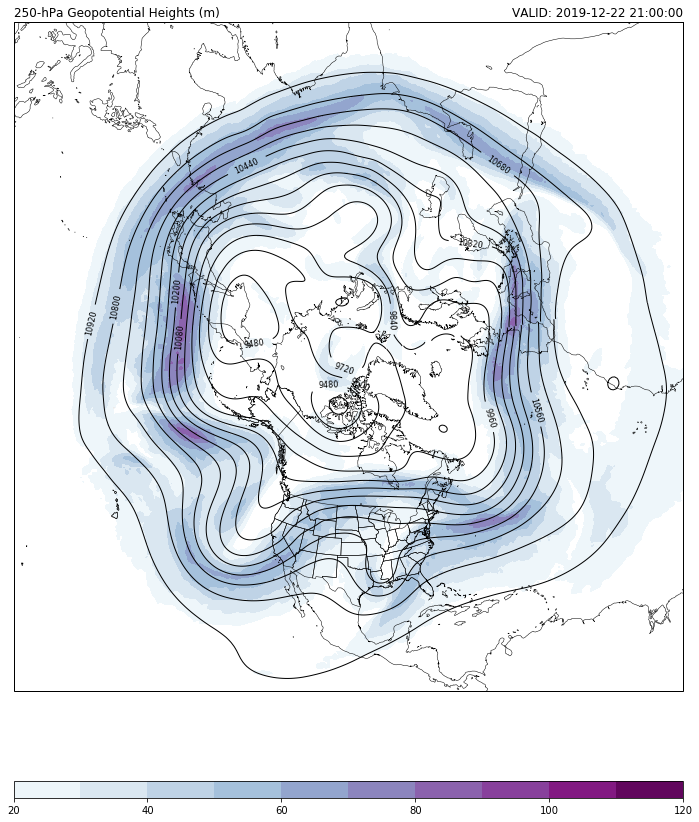

In [9]:
datacrs = ccrs.PlateCarree()
plotcrs = ccrs.NorthPolarStereo(central_longitude=-100.0)

# Make a grid of lat/lon values to use for plotting with Basemap.
lons, lats = np.meshgrid(lon, lat)

for iii in range(0,len(times),1):
    print(iii)
    fig = plt.figure(1, figsize=(12., 13.))
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02],
                           bottom=.07, top=.99, hspace=0.01, wspace=0.01)

    ax = plt.subplot(gs[0], projection=plotcrs)
    ax.set_title('250-hPa Geopotential Heights (m)', loc='left')
    ax.set_title('VALID: {}'.format(vtimes[iii]), loc='right')

    #   ax.set_extent([west long, east long, south lat, north lat])
    ax.set_extent([-180, 180, 10, 90], ccrs.PlateCarree())
    ax.coastlines('50m', edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    clev250 = np.arange(9000, 12000, 120)
    cs = ax.contour(lons, lats, Z_250[iii,:,:], clev250, colors='k',
                    linewidths=1.0, linestyles='solid', transform=datacrs)
    plt.clabel(cs, fontsize=8, inline=1, inline_spacing=10, fmt='%i',
               rightside_up=True, use_clabeltext=True)

    clevsped250 = np.arange(20, 130, 10)
    cmap = plt.cm.get_cmap('BuPu')
    cf = ax.contourf(lons, lats, wspd250[iii,:,:], clevsped250, cmap=cmap, transform=datacrs)
    cax = plt.subplot(gs[1])
    cbar = plt.colorbar(cf, cax=cax, orientation='horizontal', extend='max', extendrect=True)

    plt.savefig('../figures/test' + str(iii) + '.png')

